<a href="https://colab.research.google.com/github/Rubaikaa/Data-Science-Internship/blob/main/Task4_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task # 4**
**Predicting House Prices** Using the California Housing Dataset.

**Description:**
Build a regression model from scratch to predict house prices using the California Housing Dataset.

Steps:

**Data Preprocessing:**
Normalize numerical features and preprocess categorical variables.

**Model Implementation:**
Implement Linear Regression, Random Forest, and XGBoost models from scratch (avoid using built-in libraries like sklearn.linear_model).

**Performance Comparison:**
Compare the models using RMSE and R² metrics.

**Feature Importance:**
Visualize feature importance for tree-based models.

In [1]:
!pip install numpy pandas matplotlib seaborn


# **Import Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# **Load the Dataset**

In [4]:
from google.colab import files

# Upload the file manually
uploaded = files.upload()

# Load the dataset
df = pd.read_csv("/content/housing.csv")

# Display the first few rows
df.head()

Saving housing.csv to housing (1).csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **Data Preprocessing**

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Handle missing values by filling them with the median
df.fillna(df.median(numeric_only=True), inplace=True)

# Normalize numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('median_house_value')
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Encode categorical variable
# Use sparse_output instead of sparse
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['ocean_proximity']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Concatenate encoded categorical features
df = pd.concat([df.drop(columns=['ocean_proximity']), encoded_df], axis=1)

# Define features and target variable
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check dataset shape
X_train.shape, X_test.shape

((16512, 13), (4128, 13))

# **Implement Linear Regression from Scratch**

In [8]:
class LinearRegressionCustom:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            error = y_pred - y

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error)

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train the Linear Regression model
lr_model = LinearRegressionCustom(learning_rate=0.01, epochs=1000)
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr}")
print(f"R² Score: {r2_lr}")


Linear Regression Performance:
RMSE: 91815.95924793396
R² Score: 0.35667638786060685


# **Implement Random Forest from Scratch**

In [12]:
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1 or len(y) == 0: # Check if y is empty
            if len(y) == 0:  # Handle empty y
                return None  # Return None if y is empty
            else:
                return Counter(y).most_common(1)[0][0]

        best_feature = np.random.randint(0, X.shape[1])
        threshold = np.median(X[:, best_feature])
        left_mask = X[:, best_feature] <= threshold
        right_mask = ~left_mask

        return {
            "feature": best_feature,
            "threshold": threshold,
            "left": self._grow_tree(X[left_mask], y[left_mask], depth + 1),
            "right": self._grow_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def predict(self, X):
        return np.array([self._predict_row(row, self.tree) for row in X])

    def _predict_row(self, row, node):
        # Handle case when node is None (due to empty branch)
        if node is None:
            return 0  # or any other suitable default value

        if not isinstance(node, dict):
            return node
        if row[node["feature"]] <= node["threshold"]:
            return self._predict_row(row, node["left"])
        else:
            return self._predict_row(row, node["right"])

# **Compare Model Performance**

In [14]:
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1 or len(y) == 0: # Check if y is empty
            if len(y) == 0:  # Handle empty y
                return None  # Return None if y is empty
            else:
                return Counter(y).most_common(1)[0][0]

        best_feature = np.random.randint(0, X.shape[1])
        threshold = np.median(X[:, best_feature])
        left_mask = X[:, best_feature] <= threshold
        right_mask = ~left_mask

        return {
            "feature": best_feature,
            "threshold": threshold,
            "left": self._grow_tree(X[left_mask], y[left_mask], depth + 1),
            "right": self._grow_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def predict(self, X):
        return np.array([self._predict_row(row, self.tree) for row in X])

    def _predict_row(self, row, node):
        # Handle case when node is None (due to empty branch)
        if node is None:
            return 0  # or any other suitable default value

        if not isinstance(node, dict):
            return node
        if row[node["feature"]] <= node["threshold"]:
            return self._predict_row(row, node["left"])
        else:
            return self._predict_row(row, node["right"])

# Assuming you have your DecisionTree class defined
class RandomForest:
    def __init__(self, n_trees=100, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        for _ in range(self.n_trees):
            # Create a bootstrap sample
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            # Train a decision tree on the bootstrap sample
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Convert to numpy array
        X = np.array(X)

        # Get predictions from each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])

        # Return the average prediction
        return np.mean(predictions, axis=0)

# Train the Random Forest model
rf_model = RandomForest(n_trees=100, max_depth=5)  # Adjust parameters as needed
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf}")
print(f"R² Score: {r2_rf}")

Random Forest Performance:
RMSE: 206634.4175124923
R² Score: -2.2583554607543


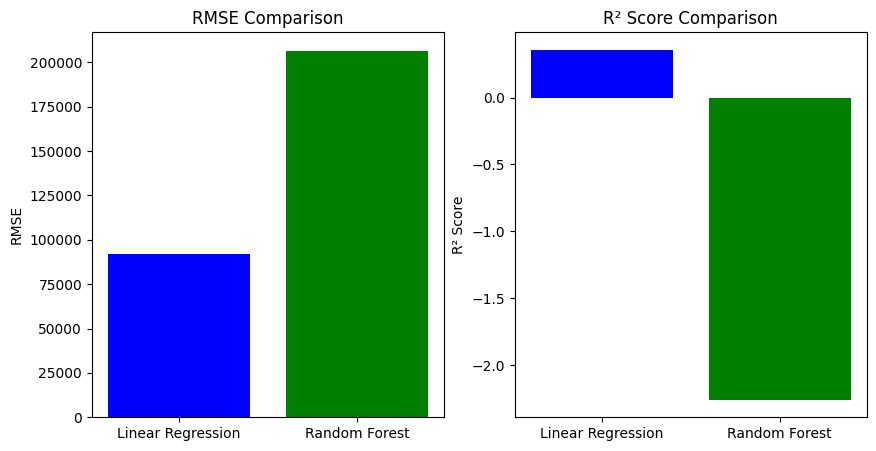

In [16]:
models = ["Linear Regression", "Random Forest"]
rmse_values = [rmse_lr, rmse_rf]
r2_values = [r2_lr, r2_rf]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['blue', 'green'])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")

plt.show()
